In [93]:
from pystencils.session import *
import numpy as np
from matplotlib import patches

In [94]:
r = 26
s = 52
h = 100
l1 = 120
l2 = 120

x = l1+l2+s
y = r+h

domain_size = (x, y)

# create arrays
c_arr = np.zeros(domain_size)
U_arr = np.zeros(domain_size)
D_arr = np.ones(domain_size)

# create fields
c, c_next = ps.fields("c, c_next: [2d]", c=c_arr, c_next=c_arr)
D, U = ps.fields("D, U: [2d]", D=D_arr, U=U_arr)

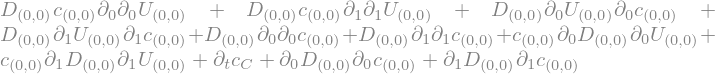

In [95]:
spatial = lambda _axis_: ps.fd.diff(D[0,0]*(ps.fd.diff(c[0,0],_axis_)+c[0,0]*ps.fd.diff(U[0,0],_axis_)),_axis_)
spatial = ps.fd.expand_diff_products(ps.fd.expand_diff_products(spatial(0)+spatial(1)))
temporal = ps.fd.transient(c)
diff_pde = temporal+spatial
diff_pde.simplify()

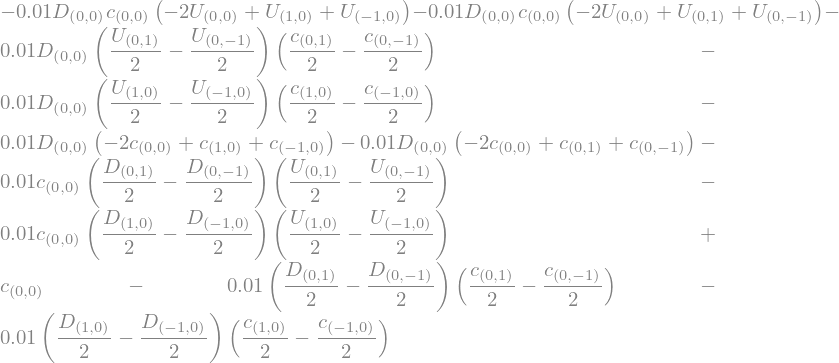

In [96]:
discretization =  ps.fd.Discretization2ndOrder(dx = 1, dt=0.01)(diff_pde.simplify())
discretization

In [97]:
ast = ps.create_kernel([ps.Assignment(c_next[0,0], discretization)])
kernel = ast.compile()

In [98]:
def boundary_handling(c):
    # left inflow border
    c[0, :] = 1.0
    # Reflection boundary at the upper, lower wall
    c[:, 0] = c[:, 1]
    c[:, -1] = c[:, -2]
    # Sink at the outflow border
    c[-1, :] = 0

    #No concentration in the pore walls
    c[l1:l1+s, 0:h] = 0
    # Reflection boundary at the pore walls
    c[l1, 0:h]=c[l1-1, 0:h]
    c[l1+s, 0:h]=c[l1+s+1, 0:h]
    c[l1:l1+s, h] = c[l1:l1+s, h+1]
    


    # Some source inside the domain
    #c[10: 15, 25:30] = 1.0
    #c[20: 25, 60:65] = 1.0

c_tmp_arr = np.empty_like(c_arr)
def timeloop(steps=1):
    global c_arr, c_tmp_arr
    for i in range(steps):
        boundary_handling(c_arr)
        kernel(c=c_arr, c_next=c_tmp_arr, D = D_arr, U=U_arr)
        c_arr, c_tmp_arr = c_tmp_arr, c_arr
    return c_arr

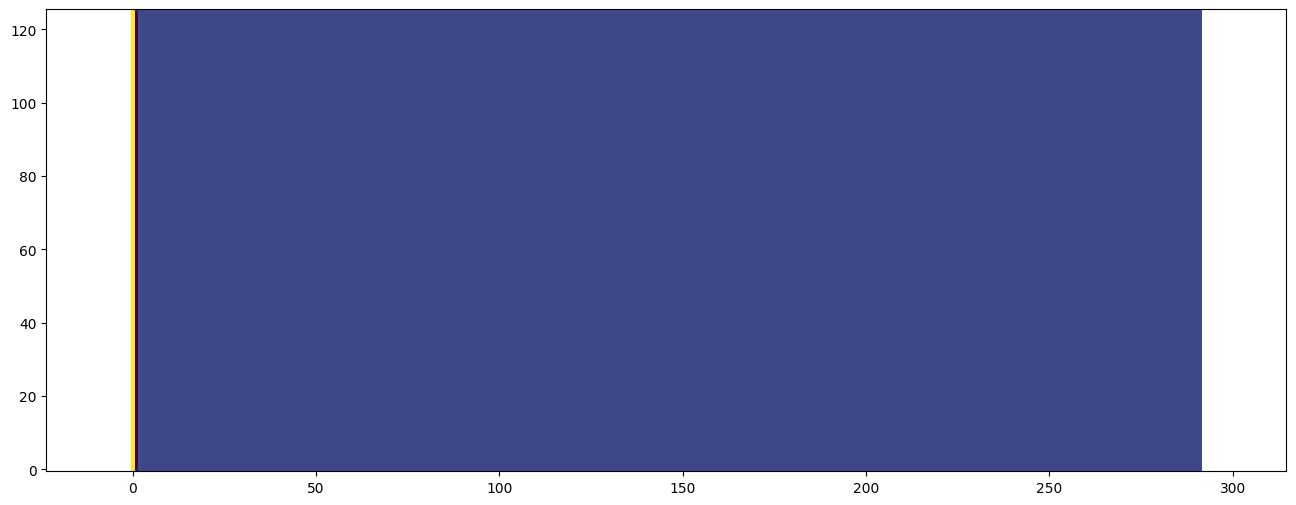

In [109]:
import matplotlib
ani = ps.plot.scalar_field_animation(timeloop, rescale=True, frames=120, interpolation='nearest')

In [110]:
timeloop()

array([[ 1.        ,  1.        ,  1.        , ...,  1.        ,
         1.        ,  1.        ],
       [-0.25958106, -0.29085048, -0.29085048, ..., -0.29085048,
        -0.29085048, -0.25958106],
       [ 0.02726524,  0.03380338,  0.03380338, ...,  0.03380338,
         0.03380338,  0.02726524],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

In [51]:
c_arr

array([[ 1.00e+00,  1.00e+00,  1.00e+00, ...,  1.00e+00,  1.00e+00,
         1.00e+00],
       [ 0.00e+00, -2.02e-02, -2.02e-02, ..., -2.02e-02, -2.02e-02,
         0.00e+00],
       [ 0.00e+00,  1.00e-04,  1.00e-04, ...,  1.00e-04,  1.00e-04,
         0.00e+00],
       ...,
       [ 0.00e+00,  0.00e+00,  0.00e+00, ...,  0.00e+00,  0.00e+00,
         0.00e+00],
       [ 0.00e+00,  0.00e+00,  0.00e+00, ...,  0.00e+00,  0.00e+00,
         0.00e+00],
       [ 0.00e+00,  0.00e+00,  0.00e+00, ...,  0.00e+00,  0.00e+00,
         0.00e+00]])

In [36]:
ps.jupyter.display_as_html_video(ani)

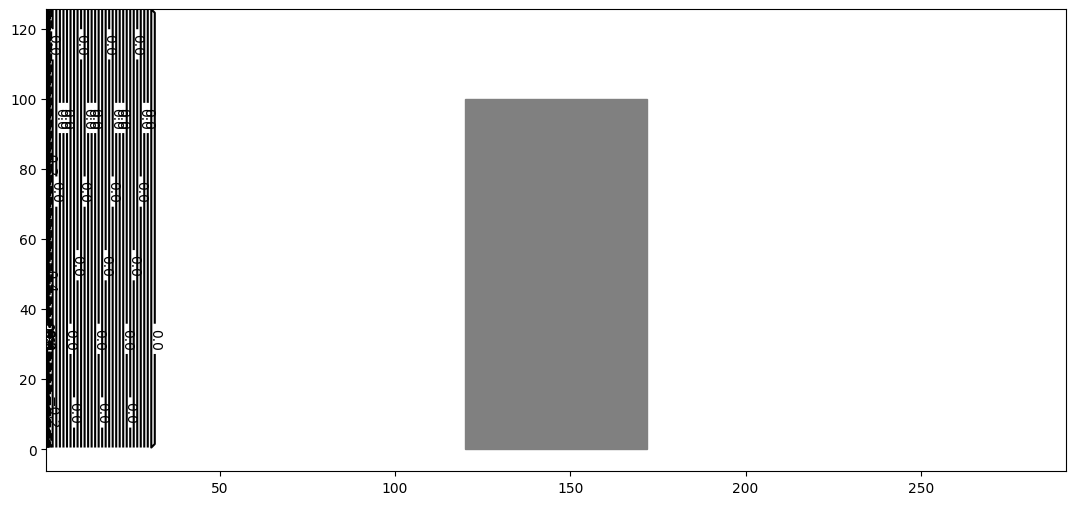

In [14]:
fig, ax  = plt.subplots()
ax.set_aspect('equal')
c = ax.contour(timeloop(10).T, origin = "lower", colors = "black")#, levels = np.arange(0, 1, 0.05))
ax.clabel(c, inline=True)
rect = patches.Rectangle((l1, 0), s, h, color = "grey")
ax.add_patch(rect)

In [100]:
domain_size = (200, 80)
dim = len(domain_size)

# create arrays
c_arr = np.zeros(domain_size)
v_arr = np.zeros(domain_size + (dim,))

# create fields
c, v, c_next = ps.fields("c, v(2), c_next: [2d]", c=c_arr, v=v_arr, c_next=c_arr)

# write down advection diffusion pde
# the equation is represented by a single term and an implicit "=0" is assumed.
adv_diff_pde = ps.fd.transient(c) - ps.fd.diffusion(c, sp.Symbol("D")) + ps.fd.advection(c, v)
adv_diff_pde

array([[1.00000000e+00, 1.00000000e+00, 1.00000000e+00, ...,
        1.00000000e+00, 1.00000000e+00, 1.00000000e+00],
       [3.87571412e+00, 3.87592091e+00, 3.88735727e+00, ...,
        1.01053830e+00, 1.01042635e+00, 1.01042477e+00],
       [6.75033192e+00, 6.75074542e+00, 6.77374027e+00, ...,
        1.02104369e+00, 1.02082002e+00, 1.02081685e+00],
       ...,
       [8.62783167e-06, 8.62816183e-06, 8.63886875e-06, ...,
        5.95985706e-05, 5.96216372e-05, 5.96199850e-05],
       [4.31246461e-06, 4.31262966e-06, 4.31797976e-06, ...,
        2.97728992e-05, 2.97844181e-05, 2.97835925e-05],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])